# fecthing stacks; pre-process for later segmentation

#### Binary the feature map and fill the hole 


In [1]:
# import the necessary packages
import imutils
import matplotlib.pyplot as plt

import os
import numpy as np
from scipy import ndimage
from tqdm import tqdm  # ! this might result into problem with 'object'
import pandas as pd
import random
import glob
from skimage import io

import argparse
import time
import cv2

import tifffile
import napari

#### Import the data 

In [2]:
# write a stack of image in tif

def writeStack(stack, path, name):
#     with tifffile.TiffWriter(path+'/' + 'fMax.tif') as tif:
    with tifffile.TiffWriter(path+'/' + name) as tif:
      for i in range(stack.shape[0]):
        filename = f"image_{i}"
        tif.save(stack[i,...], photometric='minisblack', description=filename, metadata=None)

In [3]:
# visualization for two images

def subShow(IMG1, IMG2):
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(IMG1, cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(IMG2, cmap='gray')
    plt.show()

In [8]:
# 测试两张图片之间的差异

featureMap = np.load('fMaxPad.npy')
rawGray = np.load('rawGray.npy')

print(featureMap.shape, featureMap.max())

(19, 20, 1040, 1392) 255


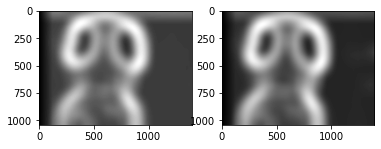

94 202


In [6]:
subShow(test[0,0,:,:], test[0,19,:,:])
print(test[0,0,:,:].max(), test[0,19,:,:].max())

In [4]:
# load data. the dtype is uint8

savedPath = 'F:/Data/MLID/LM/fMax_zebrafish/padMax'

rawGray = np.load(savedPath+'/final/rawGray.npy')
featureMap = np.load(savedPath+'/final/fMaxPad.npy')

In [5]:
# write the feature map as tif for imagej

writeStack(featureMap[0,...], savedPath, 'fMax.tif')
writeStack(rawGray[0,...], savedPath, 'raw.tif')

# test = io.imread(savedPath + './testImagej/'+ 'fMax.tif')  
# viewer = napari.view_image(test)
# napari.run() 

In [2]:
# read into the raw data

path = 'F:/Data/MLID/LM/fMax_zebrafish/Pad/final/'

test = np.load(path + 'fMaxPad.npy')

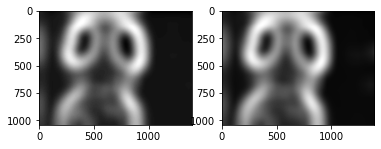

In [10]:
NUM = 19
# plt.imshow(test[0,NUM,...],cmap='gray')

subShow(test[0,0,...],test[0,19,...] )


In [13]:
import napari

viewer1 = napari.view_image(test[0,...])  # visualize the volume in layers
napari.run() 

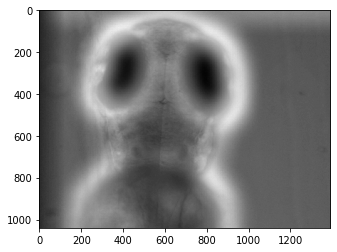

In [6]:
# 将两副图片进行合并显示

NUM = 0  # use the bottom image for the standard seg

testMap = featureMap[0,NUM,...]
testIMG = rawGray[0,NUM,...]

sumImg = testMap+testIMG
sumImg = np.interp(sumImg, (sumImg.min(), sumImg.max()), (0, 1))

plt.imshow(sumImg, cmap='gray')


In [21]:
test1 = test[1,...]
test2 = np.mean(test1, axis=0)

In [9]:
# binary the mask with otsu in stacks
from skimage import data,filters
from skimage.morphology import reconstruction

def binaryMap(stack, refNUM):
    biStacks = []
    for i in range(stack.shape[0]):
        refMapT = stack[i,refNUM,...]  # refNUM image as reference
        threshT = filters.threshold_otsu(refMapT)
        
        stackT = stack[i,...] > (threshT)
        stackT[:,1039:,:] = 1
        
        # filled the hole
        biStack = []
        for j in range(stackT.shape[0]):
            
            seed = np.copy(stackT[j,...])
            seed[1:-1, 1:-1] = stackT[j,...].max()
            mask = stackT[j,...]

            filledT = reconstruction(seed, mask, method='erosion')
            
            biStack.append(filledT)
            
        biStacks.append(np.asarray(biStack))
    return biStacks
            

In [12]:
biStacks = binaryMap(featureMap[:15,...], 19)
biStacks = np.asarray(biStacks)

In [37]:
import napari

viewer1 = napari.view_image(biStacks[0,...])  # visualize the volume in layers
napari.run() 

In [15]:
# saved the processed data
savedPath = 'F:/Data/MLID/LM/fMax_zebrafish/padMax'

stackScale = np.interp(biStacks, (biStacks.min(), biStacks.max()), (0, 255))
stackScale = stackScale.astype('uint8')
np.save(savedPath + '/final/biMasks.npy', stackScale)

MemoryError: Unable to allocate 3.24 GiB for an array with shape (15, 20, 1040, 1392) and data type float64

In [5]:
# 记载更新其他的几个数据
# savedPath = 'F:/Data/MLID/LM/fMax_zebrafish/padMax'

gray = np.load(savedPath + '/final/rawGray.npy')
np.save(savedPath + '/final/rawGray15.npy', gray[:15,...])

fMap = np.load(savedPath + '/final/fMaxPad.npy')
np.save(savedPath + '/final/fMaxPad15.npy', fMap[:15,...])


In [4]:
# 单张图片上的测试
gray = np.load('rawGray15.npy')
featureMap = np.load('fMaxPad15.npy')

print(gray.shape, featureMap.shape)

(15, 20, 1040, 1392) (15, 20, 1040, 1392)


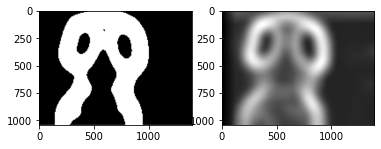

In [5]:
# 单张图片上上的测试
from skimage import data,filters

NUM = 19  # use the bottom image for the standard seg

testMap = featureMap[0,NUM,...]
thresh = filters.threshold_otsu(testMap)
binaryOtsu = testMap > (thresh)

# 封闭底部的空腔
# binaryOtsu = binaryOtsu.astype(int)
binaryOtsu[1039:,...] = 1

subShow(binaryOtsu, testMap)

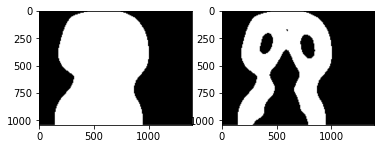

In [21]:
# fill the hole

from skimage.morphology import reconstruction

seed = np.copy(binaryOtsu)
seed[1:-1, 1:-1] = binaryOtsu.max()
mask = binaryOtsu

filled = reconstruction(seed, mask, method='erosion')

subShow(filled, binaryOtsu)

In [10]:
binary_test = np.load('biMasks15.npy')*255

In [12]:
print(binary_test.max())

255


In [13]:
import napari

viewer1 = napari.view_image(binary_test[0,...])  # visualize the volume in layers
napari.run() 